<a href="https://colab.research.google.com/github/MAHDI-Imen/PACBayes/blob/main/BML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Bayesian Linear Regression

In [ ]:
# Generate data
def generate_data(n_samples=15, scale = np.sqrt(0.5)):
    x = 2 * np.pi * torch.rand(n_samples)
    y = torch.sin(x) + torch.randn_like(x) * scale  # Gaussian noise with variance 1/4
    return x, y

def generate_data2(n_samples=15, scale = 0.5):
    x = torch.linspace(0,2*np.pi,n_samples)
    y = torch.sin(x) + torch.randn_like(x) * scale  # Gaussian noise with variance 1/4
    return x, y

In [ ]:
# Feature mapping function
def phi(x, degree):
    return torch.stack([x**i for i in range(degree + 1)], dim=1)

# Closed-form solution for Bayesian linear regression with L2 regularization
def bayesian_linear_regression(x, y, sigma2, sigma2_pi, degree):
    Phi = phi(x, degree)
    n, d = Phi.shape

    # Calculate posterior parameters
    Phi_T = torch.transpose(Phi, 0, 1)
    A = 1 / sigma2 * torch.mm(Phi_T, Phi) + 1 / sigma2_pi * torch.eye(d)
    A_inv = torch.inverse(A)
    w_hat = 1 / sigma2 * torch.mm(torch.mm(A_inv, Phi_T), y.unsqueeze(1))

    # Predictions
    y_pred = torch.mm(Phi, w_hat)
    w_hat = w_hat.squeeze()
    return w_hat, A_inv, y_pred

def negative_log_likelihood(x, y, sigma2, degree, w):
  return .5 * np.log( 2 * np.pi * sigma2) + ((y- phi(x,degree=degree)@w_hat)**2).mean() /(2*sigma2)

def get_loss_XY(x, y, sigma2,degree, n_samples, A_inv, w):
  Phi = phi(x, degree)
  Phi_T = torch.transpose(Phi, 0, 1)
  return n_samples * negative_log_likelihood(x,y,sigma2,degree,w) + torch.trace(Phi_T@Phi@A_inv)

def get_loss_D(x, y, sigma2,degree, n_samples, A_inv, w,x_test,y_test):
  Phi = phi(x, degree)
  Phi_T = torch.transpose(Phi, 0, 1)
  return n_samples * negative_log_likelihood(x_test,y_test,sigma2,degree,w) + torch.trace(Phi_T@Phi@A_inv)

def get_kl(sigma2_pi, A_inv,degree, w):
  return torch.trace(A_inv) / (2*sigma2_pi) - degree/2 + (w*w).sum() / (2*sigma2_pi) - .5 *torch.log(torch.det(A_inv)) + degree * np.log(sigma2_pi) / 2



def get_ln_Zxy(x, y, sigma2, sigma2_pi, degree, n_samples, A_inv, w):
  #return get_kl(sigma2_pi,A_inv,degree,w) + get_loss_XY(x, y, sigma2,degree, n_samples, A_inv, w)
  #should be the same
  Phi = phi(x, degree)
  return ((y-  Phi@w_hat)**2).sum() +  .5 * n_samples * np.log( 2 * np.pi * sigma2) + (w*w).sum() / (2*sigma2_pi) - .5 *torch.log(torch.det(A_inv)) + degree * np.log(sigma2_pi) / 2

#   Phi = phi(x, degree)
#   Phi_T = torch.transpose(Phi, 0, 1)
#   return n_samples * negative_log_likelihood(x,y,sigma2,degree,w) + torch.trace(Phi_T@Phi@A_inv)

In [ ]:
sigma2_pi = 1 / 0.005
sigma2 = 0.5
n_samples = 15

1
KL Divergence: 6.2141523361206055
loss_XY: 20.361692428588867
ln_Zxy: 26.075847625732422
loss_D: 13.076940536499023

2
KL Divergence: 11.273935317993164
loss_XY: 19.98297691345215
ln_Zxy: 30.756908416748047
loss_D: 14.396855354309082

3
KL Divergence: 16.85284996032715
loss_XY: 15.605195999145508
ln_Zxy: 31.95810890197754
loss_D: 11.718328475952148

4
KL Divergence: 22.93508529663086
loss_XY: 16.00570297241211
ln_Zxy: 38.440696716308594
loss_D: 12.393871307373047

5
KL Divergence: 29.551570892333984
loss_XY: 14.571938514709473
ln_Zxy: 43.61850357055664
loss_D: 14.13060188293457

6
KL Divergence: 36.808414459228516
loss_XY: 14.906686782836914
ln_Zxy: 50.93426513671875
loss_D: 15.054197311401367

7
KL Divergence: 46.760406494140625
loss_XY: 14.540274620056152
ln_Zxy: 61.790138244628906
loss_D: 16.73537826538086



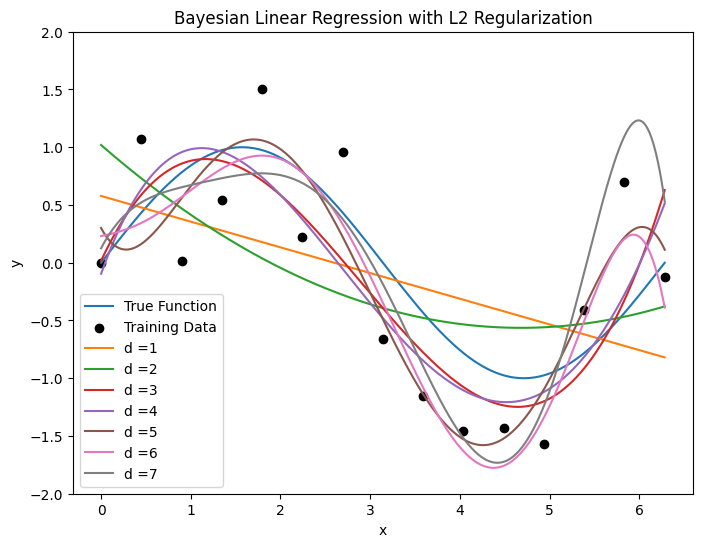

In [ ]:
max_degree = 7
# Generate data
x_train, y_train = generate_data2(n_samples=n_samples,scale=np.sqrt(sigma2))

# Plotting
plt.figure(figsize=(8, 6))

# True function and data points
x_plot = torch.linspace(0, 2 * np.pi, 1000)
y_true = torch.sin(x_plot)
#

plt.plot(x_plot.numpy(), y_true.numpy(), label='True Function')
plt.scatter(x_train.numpy(), y_train.numpy(), color='black', label='Training Data')

kl_divs = []
loss_XYs = []
loss_Ds = []
ln_Zxys = []
degrees = range(1,max_degree + 1)
for degree in degrees:
  # Bayesian linear regression
  w_hat, A_inv, y_pred = bayesian_linear_regression(x_train, y_train, sigma2, sigma2_pi, degree)
  y_plot = (w_hat.squeeze()[None,:] * phi(x_plot,degree)).sum(-1)
  # plt.plot(x_plot.numpy(), y_plot, label=f'Bayesian Linear Regression d ={degree}')
  plt.plot(x_plot.numpy(), y_plot, label=f'd ={degree}')
  print(degree)

  kl_div = get_kl(sigma2_pi, A_inv,degree, w_hat).item()
  kl_divs.append(kl_div)
  print("KL Divergence:", kl_div)
  loss_XY = get_loss_XY(x_train,y_train,sigma2,degree,n_samples,A_inv,w_hat).item()
  print("loss_XY:", loss_XY)
  loss_XYs.append(loss_XY)

  ln_Zxy = get_ln_Zxy(x_train,y_train,sigma2,sigma2_pi,degree,n_samples,A_inv,w_hat).item()
  print("ln_Zxy:", ln_Zxy)
  ln_Zxys.append(ln_Zxy)

  loss_D = get_loss_D(x_train,y_train,sigma2,degree,n_samples,A_inv,w_hat,x_plot,y_true).item()
  print("loss_D:", loss_D)
  loss_Ds.append(loss_D)
  print()

plt.title('Bayesian Linear Regression with L2 Regularization')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)
plt.legend()
plt.show()

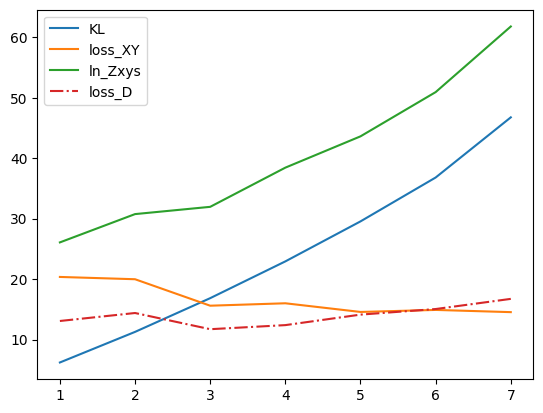

In [ ]:
plt.plot(degrees,kl_divs, label='KL')
plt.plot(degrees,loss_XYs,label='loss_XY')
plt.plot(degrees,ln_Zxys,label='ln_Zxys')
plt.plot(degrees,loss_Ds,label='loss_D',linestyle ="-.")
plt.legend(loc='upper left')

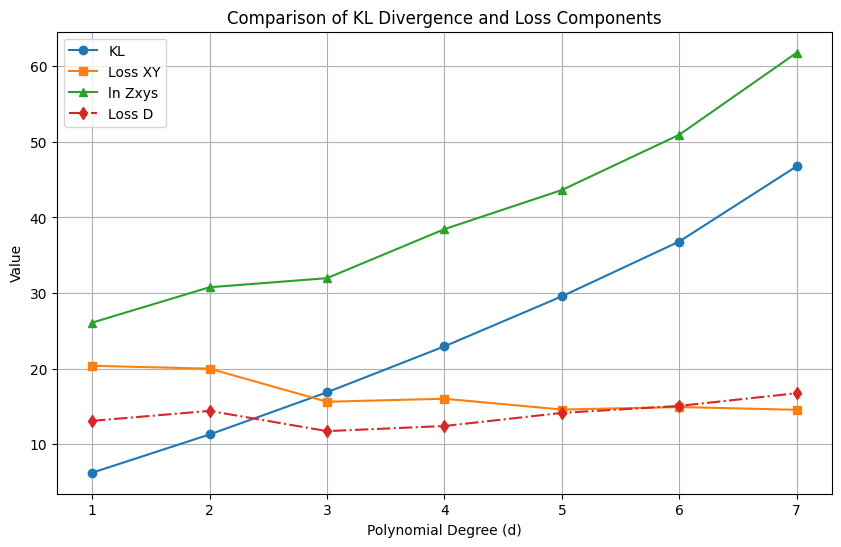

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(degrees, kl_divs, label='KL', marker='o')
plt.plot(degrees, loss_XYs, label='Loss XY', marker='s')
plt.plot(degrees, ln_Zxys, label='ln Zxys', marker='^')
plt.plot(degrees, loss_Ds, label='Loss D', linestyle="-.", marker='d')

# Add details and style
plt.title('Comparison of KL Divergence and Loss Components')
plt.xlabel('Polynomial Degree (d)')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()

In [ ]:
negative_log_likelihood(x_train, y_train, sigma2, degree, w_hat)

tensor(0.7754)

In [ ]:
negative_log_likelihood(x_plot, y_true, sigma2, degree, w_hat)

tensor(0.9218)

In [ ]:
# stop

### Part 2

### All Imports and Useful Functions

Here we are going to install and import everything we are going to need for this tutorial.

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [ ]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [ ]:
#@title Useful plot function
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = model(test_tensor)
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = net(test_tensor)

            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)

        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part I: Bayesian Logistic Regression

In linear regression, model prediction is of the continuous form $f(\pmb{x})=\pmb{w}^T\pmb{x}+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $\pmb{x}$.
For simplicity, let's consider here binary classification:
$$f(\pmb{x}) = \sigma(\pmb{w}^T\pmb{x} + b)$$
where $\sigma(t)= \frac{1}{1+e^t}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior:
$$ p(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}_0, \pmb{\Sigma}_0^2) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 4000 #@param
TEXT_LOCATION = (-5,-7)

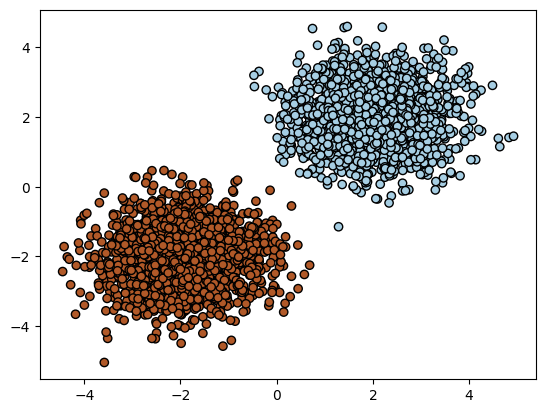

In [ ]:
# Load linear dataset
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution.

Let’s first rewrite the KL-divergence term:
$$ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = \int q_{\pmb{\theta}} \log \frac{q_{\pmb{\theta}}(\pmb{w})}{p(\pmb{w})}d\pmb{w} = \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})}\big [\log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w})\big ] $$
As for the likelihood term, the KL-divergence can be written as an expectation over the approximate distribution $q_{\pmb{\theta}}(\pmb{w})$.

By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w}) \big ) \Big ] $$
The KL-divergence is not dependent on $\mathcal{D}$, and can therefore be computed at the moment of sampling $\pmb{w}$. <br/><br/>

**Monte Carlo estimator**  
Deriving those expectations can be some tedious mathematics, or maybe not even possible. Luckily we can get estimates of the mean by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results.

Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, loss function simply boils down to minimzing at each step:

$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \Big ( \log p(y_n \vert \pmb{x}_n, \pmb{w}_s) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}_s) - \log p(\pmb{w}_s) \big ) \Big )$$
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br/><br/>

**Mean-field approximation**  
For simplicity, we assume a factorisation over the weights on each layer:
$$ q_{\pmb{\theta}}(\pmb{w}) = \prod_{l=1}^L q_{\pmb{\theta}}(\pmb{W}_l) = \prod_{l=1}^L \mathcal{N}(\pmb{W}_l; \pmb{\mu}_l, \pmb{\Sigma}^2_l) $$
As we chose a Gaussian prior $p(\pmb{W}_l)$, we also defined here $q_{\pmb{\theta}}(\pmb{W}_l)$ as a Gaussian distribution for its conjugate properties.For modelisation purposes, we take $q_{\pmb{\theta}}(\pmb{W}_l)$ to be isotropic, i.e. $\pmb{\Sigma}_l$ is diagonal.
<br/><br/>

**Reparametrization trick**  
If we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{l,s} \sim \mathcal{N}(\pmb{\mu}_{l}, \pmb{\Sigma}_{l}^2)$ from the distribution.

Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients.
$$ \pmb{w}_{l,s} = \pmb{\mu}_{l}+ \pmb{\Sigma}_{l}\odot\pmb{\varepsilon}_s$$
where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,\pmb{I}_l)$, with $\pmb{I}_l \in \mathbb{R}^l$ the identity vector of size $l$.
<br/><br/>  

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

#### Step 1: Implement a variational layer

Let's first implement variational inference for a single layer. Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.  

**Implementation constraint** Variance can not be negative. To avoid numerical issues, we will use $\pmb{\rho}$. Std can be retrieve with the following formula:
$$ \pmb{\Sigma} = \log(1 + e^{\pmb{\rho}}) $$

In [ ]:
#@title **[CODING TASK]** Implement a variational layer from scratch

class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, accumulated_kl_div):
        super().__init__()
        self.accumulated_kl_div = accumulated_kl_div

        # ============ YOUR CODE HERE ============
        # Initialize the variational parameters for weight and bias
        # with nn.Parameter.
        # Mean should be initialised to zeros and rho to ones
        #torch.nn.Parameter(torch.zeros(in_dim,hid))
        self.w_mu = nn.Parameter( torch.zeros(input_size,output_size))
        self.w_rho = nn.Parameter( torch.ones(input_size,output_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))

    def sampling(self, mu, rho):
        "Sample weights using the reparametrization trick"
        # ============ YOUR CODE HERE ============
        # Given parameter mu and rho, return sampling using
        # the reparametrization trick.
        # NB: you may look for torch.randn_like...

        return mu + torch.log(1 + torch.exp(rho)) * torch.randn_like(mu)

    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=1):
        "Computing the KL-divergence term for these weight's parameters"
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        "Usual forward function for pytorch layer"
        # ============ YOUR CODE HERE ============
        # Sample parameters w and b using self.sampling
        # Then, perform a forward pass using those sampled parameters
        w, b = self.sampling(self.w_mu, self.w_rho), self.sampling(self.b_mu, self.b_rho)
        out = x @ w + b

        # Compute KL-div loss for training
        self.accumulated_kl_div[0] += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.accumulated_kl_div[0] += self.kl_divergence(b, self.b_mu, self.b_rho)

        return out

In [ ]:
#@title **[CODING TASK]** Implement a variational layer from scratch

class LinearVariational2(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, accumulated_kl_div):
        super().__init__()
        self.accumulated_kl_div = accumulated_kl_div

        # ============ YOUR CODE HERE ============
        # Initialize the variational parameters for weight and bias
        # with nn.Parameter.
        # Mean should be initialised to zeros and rho to ones
        #torch.nn.Parameter(torch.zeros(in_dim,hid))
        self.w_mu = nn.Parameter( torch.zeros(input_size,output_size))
        self.w_rho = nn.Parameter( torch.ones(input_size,output_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))

    def sampling(self, mu, rho, num_samples):
        "Sample weights using the reparametrization trick"
        # ============ YOUR CODE HERE ============
        # Given parameter mu and rho, return sampling using
        # the reparametrization trick.
        # NB: you may look for torch.randn_like...

        sample_shape = torch.Size((num_samples,))
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)

        shape = sample_shape + self.mu.size()

        eps = torch.randn(shape, dtype=self.mu.dtype)


        return mu + eps * torch.log(1 + torch.exp(rho))
        # return mu + rho * torch.randn(num_samples mu.size())

    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=1):
        "Computing the KL-divergence term for these weight's parameters"
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        "Usual forward function for pytorch layer"
        # ============ YOUR CODE HERE ============
        # Sample parameters w and b using self.sampling
        # Then, perform a forward pass using those sampled parameters
        w, b = self.sampling(self.w_mu, self.w_rho), self.sampling(self.b_mu, self.b_rho)
        out = x @ w + b

        # Compute KL-div loss for training
        self.accumulated_kl_div[0] += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.accumulated_kl_div[0] += self.kl_divergence(b, self.b_mu, self.b_rho)

        return out

#### Step 2: Variational Logistic Regression

Now, let's use this `LinearVariational` layer in a Logistic regression model.

In [ ]:
class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)
        self.fc_var =  LinearVariational(input_size, 1,self.accumulated_kl_div)

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x):
        out = self.fc_var(x)
        return torch.sigmoid(out)

class VariationalLogisticRegression2(nn.Module):
    def __init__(self, input_size, num_samples):
        super().__init__()
        self.num_samples = num_samples
        self.accumulated_kl_div = np.zeros(1)
        self.fc_var =  LinearVariational2(input_size, 1,self.accumulated_kl_div)

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x, num_samples = None):
        if num_samples is None:
          num_samples = self.num_samples
        x = torch.Tensor.repeat(x, num_samples)

        out = self.fc_var(x)
        return torch.sigmoid(out)


def elbo(input, target, model):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]

def get_negative_log_likelihood(input, target):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood

def get_kl(input, model):
    return model.accumulated_kl_div[0] / input.shape[0]

def get_all(input, target, model):
  negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum() / input.shape[0]
  kl_value = model.accumulated_kl_div[0] / input.shape[0]
  elbo_value = negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]
  return elbo_value, negative_log_likelihood, kl_value

We can now train our variational model as any other network in Pytorch

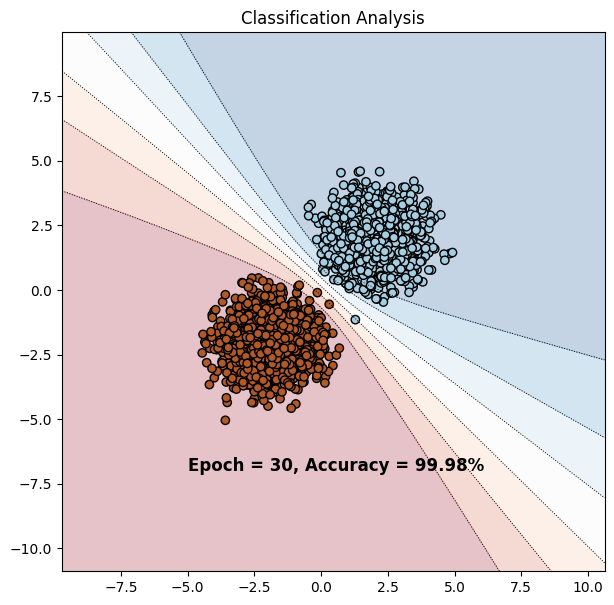

In [ ]:
var_net = VariationalLogisticRegression(input_size=X.shape[1])
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1,  weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(30):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # Computing prediction for visualization purpose
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()

    # For plotting and showing learning process at each epoch
    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

**[Question 1.3]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

**[Answer 1.3]:**

On observe l'erreur épistémique mais les courbes de niveaux sont différentes de celles obtenus pour l'approximation de Laplace. On est globalement plus confiants dans nos prédictions.

## Part II: Bayesian Neural Networks


Moving on to a non-linear dataset, we will leverage our variational implementation to a Multi-Layer Perceptron (MLP). Finally, we will also review one last approximate inference method which has the particularity to be very easy to implement: Monte-Carlo Dropout

### II.0 Dataset

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

NOISE_MOON = 0.04 #@param
WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 200 #@param
TEXT_LOCATION = (-1.5, -1.5)

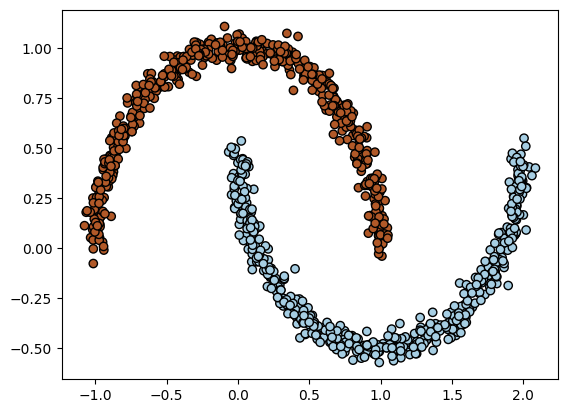

In [ ]:
# Load two moons dataset
X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### II.1 Variational Inference with Bayesian Neural Networks

Such as for Logistic Regression, we will use `LinearVariational` layer to define a MLP with 1 hidden layer.





In [ ]:
#@title **[CODING TASK]** Implement a Variational MLP

class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)


        # ============ YOUR CODE HERE ============
        # Define a variational MLP with 1 hidden layer and ReLU activation

        self.mlp = nn.Sequential(LinearVariational(input_size,
                                                   hidden_size,
                                                   self.accumulated_kl_div),
                                 nn.ReLU(),
                                 LinearVariational(hidden_size,
                                                   1,
                                                   self.accumulated_kl_div))

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        x = self.mlp(x)
        return torch.sigmoid(x)

We can now train our variational model as any other network in Pytorch

HIDDEN SIZE = 3

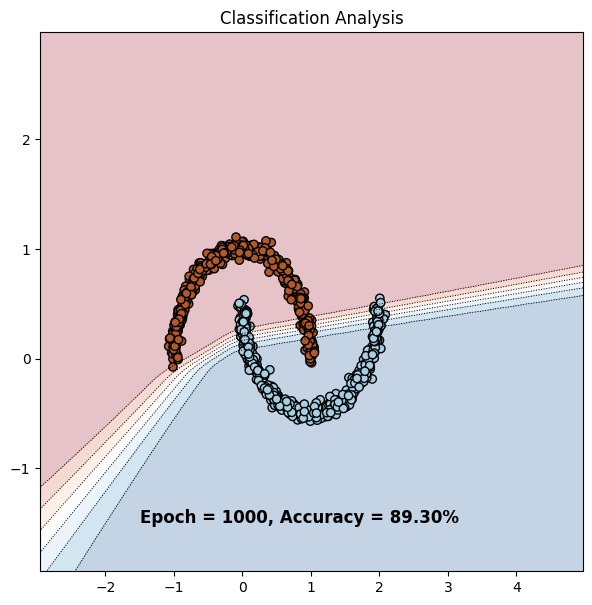

In [ ]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=3)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))



for epoch in range(1000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%50==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

HIDDEN SIZE = 4

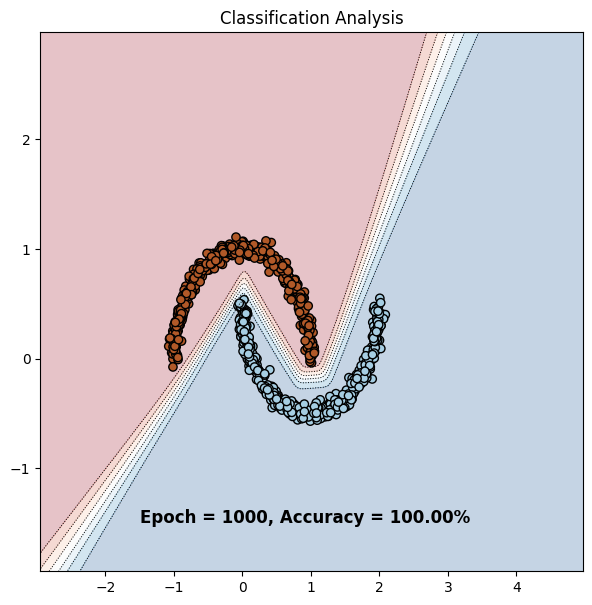

In [ ]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=4)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))



for epoch in range(1000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%50==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

In [ ]:
negative_log_likelihoodss = []
klss = []

In [ ]:
negative_log_likelihoods = []
kls = []
hidden_sizes = range(1,11) #[16,128,256,512,1024]
for hidden_size in hidden_sizes:
  var_net = VariationalMLP(input_size=X.shape[1], hidden_size=hidden_size)
  var_net.train()
  optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)

  for epoch in range(1000):  # loop over the dataset multiple times
      # zero the parameter gradients
      optimizer.zero_grad()
      var_net.reset_kl_div()

      # forward + backward + optimize
      output = var_net(X).squeeze()
      loss = elbo(output, y, var_net)
      loss.backward()
      optimizer.step()

      # # For plotting and showing learning process at each epoch
      # if (epoch+1)%50==0:
      #     # Computing prediction for visualization purpose
      #     preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
      #     for i in range(NB_SAMPLES):
      #         preds[i] = var_net(X)
      #     pred = preds.mean(0).squeeze()
      #     accuracy = ((pred>=0.5) == y).float().mean()

      #     plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)
  with torch.no_grad():
    tot_kl = 0.
    tot_negative_log_likelihood = 0.

    var_net.reset_kl_div()
    for i in range(NB_SAMPLES):
      output = var_net(X).squeeze()
      elbo_value,negative_log_likelihood,kl = get_all(output,y,var_net)
      tot_kl += kl.item()
      tot_negative_log_likelihood += negative_log_likelihood.item()
    negative_log_likelihoods.append(tot_negative_log_likelihood / NB_SAMPLES)
    kls.append(tot_kl / NB_SAMPLES)
negative_log_likelihoodss.append(negative_log_likelihoods)
klss.append(kls)

In [ ]:
negative_log_likelihoodss

[[0.5575282740592956,
  0.5570662540197372,
  0.5574617294073105,
  0.5046845982074738,
  0.5048307082653045,
  0.504606952548027,
  0.5048429662585259,
  0.5040593547224999,
  0.504347656071186,
  0.504357995569706],
 [0.5576951604485512,
  0.5550990027189254,
  0.5555883188843727,
  0.504681168615818,
  0.5551207912564278,
  0.5043823303580284,
  0.5042070412635803,
  0.5044738156199455,
  0.5045285030007363,
  0.5045108976960182]]

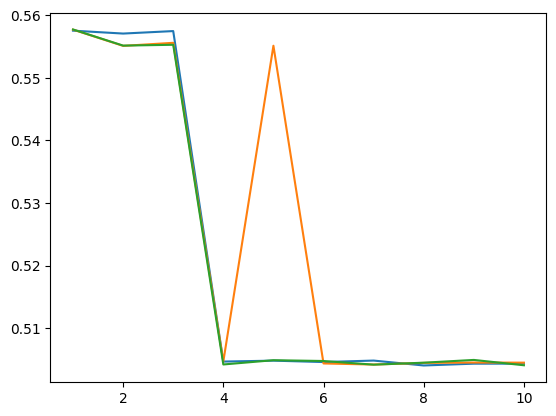

In [ ]:
plt.plot(hidden_sizes,np.array(negative_log_likelihoodss).T);

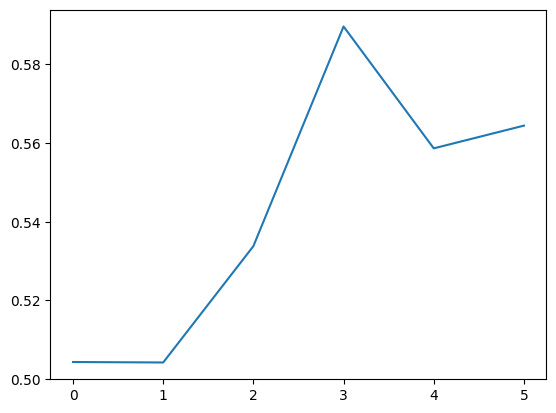

In [ ]:
plt.plot(negative_log_likelihoods)

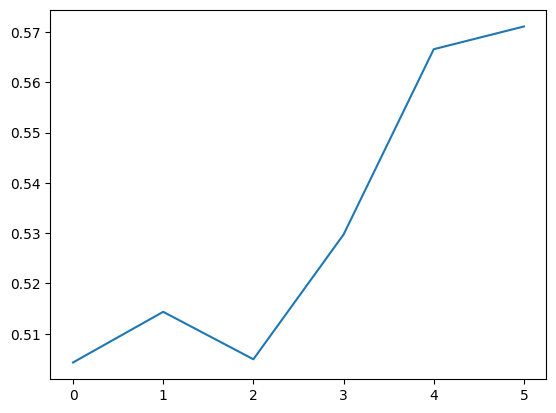

In [ ]:
plt.plot(negative_log_likelihoods)


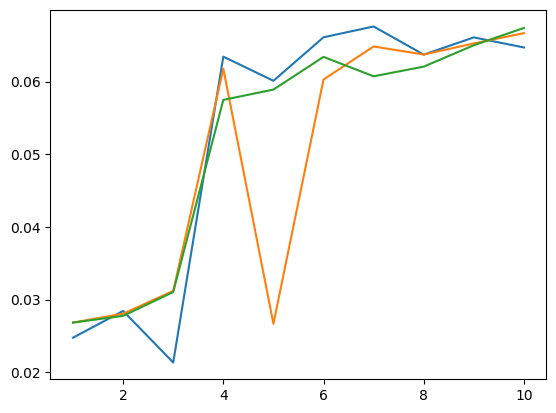

In [ ]:
plt.plot(hidden_sizes,np.array(klss).T);

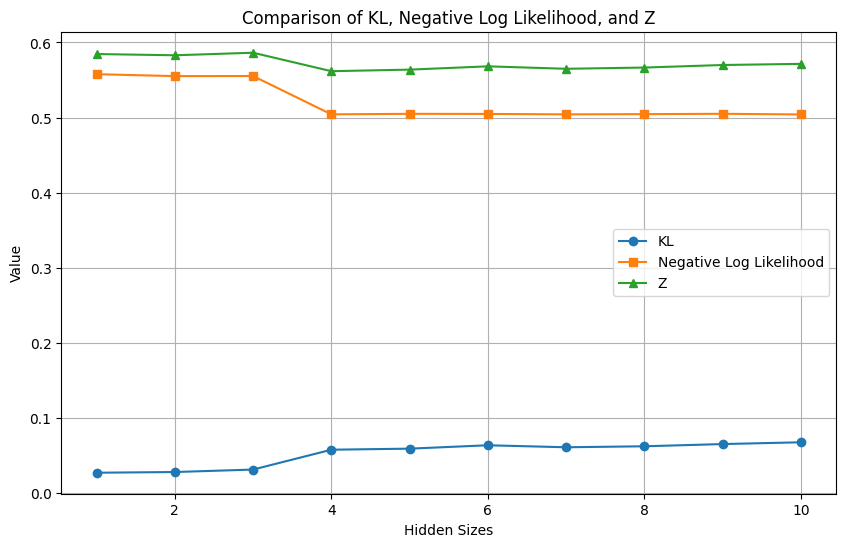

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(hidden_sizes, np.array(kls).T, label="KL", marker='o')
plt.plot(hidden_sizes, np.array(negative_log_likelihoods).T, label="Negative Log Likelihood", marker='s')
plt.plot(hidden_sizes, np.array(kls).T + np.array(negative_log_likelihoods).T, label="Z", marker='^')

# Add details and style
plt.title('Comparison of KL, Negative Log Likelihood, and Z')
plt.xlabel('Hidden Sizes')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

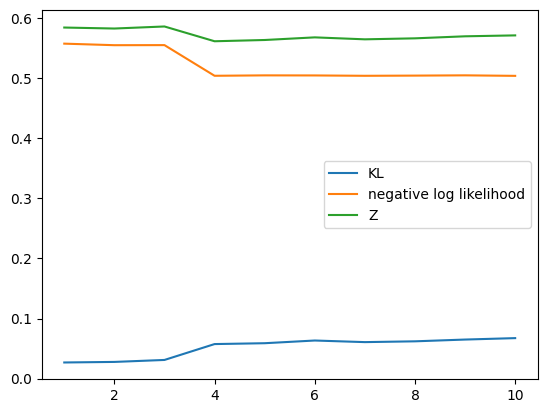

In [ ]:
plt.plot(hidden_sizes,np.array(kls).T,label = "KL");
plt.plot(hidden_sizes,np.array(negative_log_likelihoods).T,label="negative log likelihood");
plt.plot(hidden_sizes,np.array(kls).T + np.array(negative_log_likelihoods).T,label="Z");
plt.legend();

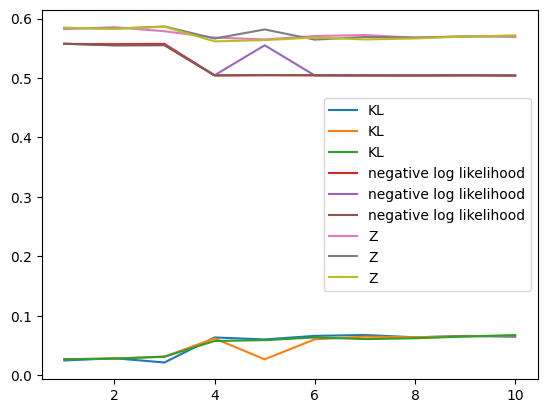

In [ ]:
plt.plot(hidden_sizes,np.array(klss).T,label = "KL");
plt.plot(hidden_sizes,np.array(negative_log_likelihoodss).T,label="negative log likelihood");
plt.plot(hidden_sizes,np.array(klss).T + np.array(negative_log_likelihoodss).T,label="Z");
plt.legend();

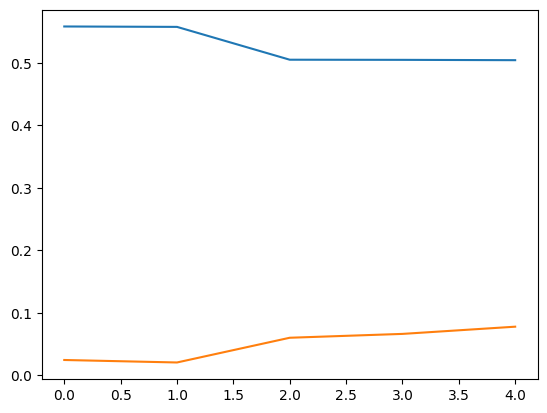

In [ ]:
plt.plot(negative_log_likelihoods)

plt.plot(kls)

real dataset

In [ ]:
#%pip install ucimlrepo

In [ ]:
import pandas as pd

In [ ]:
from ucimlrepo import fetch_ucirepo



In [ ]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
wine_quality_df = wine_quality.data.original.drop('quality',axis = 1)
y = wine_quality.data.targets

red_wine_quality_df = wine_quality_df.loc[wine_quality_df['color'] == 'red'].drop('color',axis = 1)
white_wine_quality_df = wine_quality_df.loc[wine_quality_df['color'] == 'white'].drop('color',axis = 1)


wine_quality_df.head()

X_red = red_wine_quality_df.to_numpy().squeeze()
y_red = wine_quality.data.targets.loc[wine_quality_df['color'] == 'red'].to_numpy()
X_white = white_wine_quality_df.to_numpy().squeeze()
y_white = wine_quality.data.targets.loc[wine_quality_df['color'] == 'white'].to_numpy()
wine_quality_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red


In [ ]:
np.unique(y_white)

array([3, 4, 5, 6, 7, 8, 9])

In [ ]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
breast_cancer_df = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X_breast = np.array(breast_cancer_df)
breast_cancer_df.head()

NameError: name 'breast_df' is not defined

In [ ]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=4)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))



for epoch in range(1000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%50==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

#Draft

In [ ]:
stop

NameError: name 'stop' is not defined

# TP 2: Approximate Inference in Classification

In classification taks, even for a mere Logistic Regression, we don't have access to a closed form of the posterior $p(\pmb{w} \vert \mathcal{D})$. Unlike in Linear regression, the likelihood isn't conjugated to the Gaussian prior anymore. We ill need to approximate this posterior.

During this session, we will explore and compare approximate inference approaches on 2D binary classification datasets. Studied approaches include Laplacian approximation, variational inference with mean-field approximation and Monte Carlo dropout.

**Goal**: Take hand on approximate inference methods and understand how they works on linear and non-linear 2D datasets.

### All Imports and Useful Functions

Here we are going to install and import everything we are going to need for this tutorial.

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [ ]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [ ]:
#@title Useful plot function
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = model(test_tensor)
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = net(test_tensor)

            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)

        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part I: Bayesian Logistic Regression

In linear regression, model prediction is of the continuous form $f(\pmb{x})=\pmb{w}^T\pmb{x}+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $\pmb{x}$.
For simplicity, let's consider here binary classification:
$$f(\pmb{x}) = \sigma(\pmb{w}^T\pmb{x} + b)$$
where $\sigma(t)= \frac{1}{1+e^t}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior:
$$ p(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}_0, \pmb{\Sigma}_0^2) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

### I.0 Dataset

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 400 #@param
TEXT_LOCATION = (-5,-7)

In [ ]:
# Load linear dataset
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### I.1 Maximum-A-Posteriori Estimate


In this "baseline", we reduce our posterior distribution $p(\pmb{w} | \mathcal{D})$ to a point estimate $\pmb{w}_{MAP}$. For a new sample $\pmb{x^*}$, the predictive distribution can then be approximated by
$$ p(\mathbf{y} = 1|\pmb{x^*},\mathcal{D}) = \int p(\mathbf{y} =1 |\pmb{x},\pmb{w})p(\pmb{w} | \mathcal{D})d\pmb{w} \approx p(y =1 |\pmb{x},\pmb{w}_{\textrm{MAP}}).$$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum-A-Posteriori minimum given by:
$$ \pmb{w}_{\textrm{MAP}} = arg \max_{\pmb{w}} p(\pmb{w} \vert \mathcal{D}) = arg \max_{\pmb{w}} p(\mathcal{D} \vert \pmb{w})p(\pmb{w}) = arg \max_{\pmb{w}} \prod_{n=1}^N p(y_n \vert \pmb{x}_n, \pmb{w})p(\pmb{w}) $$
Looking for the maximum solution of previous equation is equivalent to the minimum solution of $- \log p(\pmb{w} \vert \mathcal{D})$. In case of a Gaussian prior, it can further be derived as:
$$ \pmb{w}_{\textrm{MAP}} = arg \min_{\pmb{w}} \sum_{n=1}^N \big ( -y_n \log \sigma(\pmb{w}^T \pmb{x}_n + b) - (1-y_n) \log (1 - \sigma(\pmb{w}^T \pmb{x}_n + b)) + \frac{1}{2 \Sigma_0^2} \vert \vert \pmb{w} \vert \vert_2^2 \big ) $$

Note that:
- This actually correspond to the minimum given by the standard **cross-entropy** loss in classification with a weight decay regularization
- Unlike in linear regression, $\pmb{w}_{MAP}$ **cannot be computed analytically**
- But we can use optimization methods to compute it, e.g. **stochastic gradient descent**
- Nevertheless, we only obtain a **point-wise estimate**, and not a full distribution over parameters $\pmb{w}$


Consequently, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(\mathbf{y} = 1|\pmb{x}^*,\mathcal{D})$ on a new sample $\pmb{x}^*$ as in a deterministic model.

In [ ]:
class LogisticRegression(nn.Module):
    """ A Logistic Regression Model with sigmoid output in Pytorch"""
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.fc(x)
        return torch.sigmoid(out)

In [ ]:
#@title **[CODING TASK]** Train a Logistic Regression model with stochastic gradient descent for 20 epochs.

net = LogisticRegression(input_size=X.shape[1])
net.train()
criterion = nn.BCELoss()

# L2 regularization is included in Pytorch's optimizer implementation
# as "weigth_decay" option
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=WEIGHT_DECAY)

fig, ax = plt.subplots(figsize=(7,7))

# ============ YOUR CODE HERE ============
# Train previously defined network for 20 epochs with SGD
# and plot result for each epoch by uncommenting function below

for epoch in range(20):  # loop over the dataset multiple times
    # ============ YOUR CODE HERE ============
    optimizer.zero_grad()
    output = net.forward(X).squeeze()
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    plot_decision_boundary(net, X, y, epoch, ((output>=0.5) == y).float().mean(),
                          model_type='classic', tloc=TEXT_LOCATION)

**[Question 1.1]: Analyze the results provided by previous plot. Looking at $p(\mathbf{y}=1 | \pmb{x}, \pmb{w}_{\textrm{MAP}})$, what can you say about points far from train distribution?**

[Answer 1.1]
Les points loins de la distribution ont une prédiction aussi confiante que les points proches de la distribution d'entraînement.


### I.2 Laplace Approximation


We will use Laplace approximation to estimate the intractable posterior $p(\pmb{w} | \mathcal{D})$.

Here, $p(\pmb{w} | \mathcal{D})$ is approximated with a normal distribution $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ where:

- the mean of the normal distribution $\pmb{\mu}_{lap}$ corresponds to the mode of $p(\pmb{w} | \mathcal{D})$. In other words, it simply consists in taking the optimum weights of Maximum-A-Posteriori estimation :
$$\pmb{\mu}_{lap} = \pmb{w}_{\textrm{MAP}} = \arg \min_{\pmb{w}} -\log p(\pmb{w} | \mathcal{D})$$.
- the covariance matrix is obtained by computing the Hessian of the loss function $-\log p(\pmb{w} \vert \mathcal{D})$ at $\pmb{w}=\pmb{w}_{\textrm{MAP}}$:
$$(\pmb{\Sigma}^2_{lap})^{-1} = \nabla\nabla_{\pmb{w}} [p(\pmb{w} \vert \mathcal{D}) ]_{\pmb{w}=\pmb{w}_{\textrm{MAP}}}$$

In [ ]:
#@title **[CODING TASK]** Extract μ_lap from previously trained model.
# NB: Select only weights parameters (without bias)

# ============ YOUR CODE HERE ============
w_map = net.fc.weight.detach().numpy()

To compute the Hessian, we first compute the gradient at $\pmb{w}_{\textrm{MAP}}$:

In [ ]:
# Computing first derivative w.r.t to model's weights
optimizer.zero_grad()
output = net(X).squeeze()
loss = criterion(output, y) + net.fc.weight.norm()**2
gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]

In [ ]:
#@title **[CODING TASK]** Compute the Hessian from the previous derivative

# ============ YOUR CODE HERE ============
# Apply the same grad function on each scalar element of the gradient to get
# each raw of the Hessian. Concatenate both and compute the covariance
# by inverting the Hessian
# NB: to avoid accumulated gradient when debugging and running the cell
# multiple times, you should convert your grad results to numpy straight away

hess0 = grad(gradf_weight[0,0],net.fc.weight, create_graph=True)[0].detach().numpy()
hess1 = grad(gradf_weight[0,1],net.fc.weight, create_graph=True)[0].detach().numpy()
hess_weights = np.concatenate([hess0,hess1],axis = 0)
Sigma_laplace = hess_weights@hess_weights

We now compute the posterior approximate $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ with the parameters found.

Given this distribution, we can compute the posterior thanks to Monte-Carlo sampling and plot results for the last epoch corresponding to $\pmb{w}_{\textrm{MAP}}$:

In [ ]:
# Defining posterior distribution
laplace_posterior =  np.random.multivariate_normal(w_map.reshape(2,), Sigma_laplace, NB_SAMPLES) # .detach().numpy()

# Plotting results
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='laplace',
                       tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior)

**[Question 1.2]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

La distribution de prédictions présente l'erreur épistémique, les points loins de la distributions ont une prédiction moins confiante.

### I.3 Variational Inference

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution.

Let’s first rewrite the KL-divergence term:
$$ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = \int q_{\pmb{\theta}} \log \frac{q_{\pmb{\theta}}(\pmb{w})}{p(\pmb{w})}d\pmb{w} = \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})}\big [\log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w})\big ] $$
As for the likelihood term, the KL-divergence can be written as an expectation over the approximate distribution $q_{\pmb{\theta}}(\pmb{w})$.

By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w}) \big ) \Big ] $$
The KL-divergence is not dependent on $\mathcal{D}$, and can therefore be computed at the moment of sampling $\pmb{w}$. <br/><br/>

**Monte Carlo estimator**  
Deriving those expectations can be some tedious mathematics, or maybe not even possible. Luckily we can get estimates of the mean by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results.

Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, loss function simply boils down to minimzing at each step:

$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \Big ( \log p(y_n \vert \pmb{x}_n, \pmb{w}_s) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}_s) - \log p(\pmb{w}_s) \big ) \Big )$$
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br/><br/>

**Mean-field approximation**  
For simplicity, we assume a factorisation over the weights on each layer:
$$ q_{\pmb{\theta}}(\pmb{w}) = \prod_{l=1}^L q_{\pmb{\theta}}(\pmb{W}_l) = \prod_{l=1}^L \mathcal{N}(\pmb{W}_l; \pmb{\mu}_l, \pmb{\Sigma}^2_l) $$
As we chose a Gaussian prior $p(\pmb{W}_l)$, we also defined here $q_{\pmb{\theta}}(\pmb{W}_l)$ as a Gaussian distribution for its conjugate properties.For modelisation purposes, we take $q_{\pmb{\theta}}(\pmb{W}_l)$ to be isotropic, i.e. $\pmb{\Sigma}_l$ is diagonal.
<br/><br/>

**Reparametrization trick**  
If we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{l,s} \sim \mathcal{N}(\pmb{\mu}_{l}, \pmb{\Sigma}_{l}^2)$ from the distribution.

Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients.
$$ \pmb{w}_{l,s} = \pmb{\mu}_{l}+ \pmb{\Sigma}_{l}\odot\pmb{\varepsilon}_s$$
where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,\pmb{I}_l)$, with $\pmb{I}_l \in \mathbb{R}^l$ the identity vector of size $l$.
<br/><br/>  

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

#### Step 1: Implement a variational layer

Let's first implement variational inference for a single layer. Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.  

**Implementation constraint** Variance can not be negative. To avoid numerical issues, we will use $\pmb{\rho}$. Std can be retrieve with the following formula:
$$ \pmb{\Sigma} = \log(1 + e^{\pmb{\rho}}) $$

In [ ]:
#@title **[CODING TASK]** Implement a variational layer from scratch

class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, accumulated_kl_div):
        super().__init__()
        self.accumulated_kl_div = accumulated_kl_div

        # ============ YOUR CODE HERE ============
        # Initialize the variational parameters for weight and bias
        # with nn.Parameter.
        # Mean should be initialised to zeros and rho to ones
        #torch.nn.Parameter(torch.zeros(in_dim,hid))
        self.w_mu = nn.Parameter( torch.zeros(input_size,output_size))
        self.w_rho = nn.Parameter( torch.ones(input_size,output_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))

    def sampling(self, mu, rho):
        "Sample weights using the reparametrization trick"
        # ============ YOUR CODE HERE ============
        # Given parameter mu and rho, return sampling using
        # the reparametrization trick.
        # NB: you may look for torch.randn_like...

        return mu + rho * torch.randn_like(mu)

    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=1):
        "Computing the KL-divergence term for these weight's parameters"
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        "Usual forward function for pytorch layer"
        # ============ YOUR CODE HERE ============
        # Sample parameters w and b using self.sampling
        # Then, perform a forward pass using those sampled parameters
        w, b = self.sampling(self.w_mu, self.w_rho), self.sampling(self.b_mu, self.b_rho)
        out = x @ w + b

        # Compute KL-div loss for training
        self.accumulated_kl_div[0] += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.accumulated_kl_div[0] += self.kl_divergence(b, self.b_mu, self.b_rho)

        return out

#### Step 2: Variational Logistic Regression

Now, let's use this `LinearVariational` layer in a Logistic regression model.

In [ ]:
class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)
        self.fc_var =  LinearVariational(input_size, 1,self.accumulated_kl_div)

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x):
        out = self.fc_var(x)
        return torch.sigmoid(out)


def elbo(input, target, model):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]

We can now train our variational model as any other network in Pytorch

In [ ]:
var_net = VariationalLogisticRegression(input_size=X.shape[1])
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1,  weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(30):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # Computing prediction for visualization purpose
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()

    # For plotting and showing learning process at each epoch
    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

**[Question 1.3]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

**[Answer 1.3]:**

On observe l'erreur épistémique mais les courbes de niveaux sont différentes de celles obtenus pour l'approximation de Laplace. On est globalement plus confiants dans nos prédictions.

## Part II: Bayesian Neural Networks


Moving on to a non-linear dataset, we will leverage our variational implementation to a Multi-Layer Perceptron (MLP). Finally, we will also review one last approximate inference method which has the particularity to be very easy to implement: Monte-Carlo Dropout

### II.0 Dataset

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

NOISE_MOON = 0.04 #@param
WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 100 #@param
TEXT_LOCATION = (-1.5, -1.5)

In [ ]:
# Load two moons dataset
X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### II.1 Variational Inference with Bayesian Neural Networks

Such as for Logistic Regression, we will use `LinearVariational` layer to define a MLP with 1 hidden layer.





In [ ]:
#@title **[CODING TASK]** Implement a Variational MLP

class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)


        # ============ YOUR CODE HERE ============
        # Define a variational MLP with 1 hidden layer and ReLU activation

        self.mlp = nn.Sequential(LinearVariational(input_size,hidden_size,self.accumulated_kl_div),nn.ReLU(),LinearVariational(hidden_size,1,self.accumulated_kl_div))

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        x = self.mlp(x)
        return torch.sigmoid(x)

We can now train our variational model as any other network in Pytorch

In [ ]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=50)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(1000):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    var_net.reset_kl_div()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%50==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

### II.2 Monte Carlo Dropout

Training a neural network with randomly dropping some activations, such as with dropout layers, can actually be seen as an **approximate variational inference method**!

[Gal and Ghahramani, 2016] showed this can be fullfilled for:
- $p(\pmb{w}) = \prod_l p(\pmb{W}_l) = \prod_l \mathcal{MN}(\pmb{W}_l; 0, I/ l_i^2, I)$ $\Rightarrow$ Multivariate Gaussian distribution factorized over layers
- $q(\pmb{w}) = \prod_l q(\pmb{W}_l) = \prod_l \textrm{diag}(\varepsilon_l)\odot\pmb{M}_l $ with $\varepsilon_l \sim \textrm{Ber}(1-p_l)$.

We will now implement a MLP with dropout layers and perform Monte-Carlo sampling to obtain the predictive distribution $p(\mathbf{y} \vert \pmb{x}^*, \pmb{w})$ for a new sample $\pmb{x}^*$.

In [ ]:
#@title **[CODING TASK]** Implement a MLP with dropout (p=0.2)
# Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout
# layer should be also activated during test time.
# (Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # ============ YOUR CODE HERE ============
        #self.dropout_mlp = nn.Sequential(nn.Linear(input_size,hidden_size),nn.ReLU(),nn.Linear(hidden_size,1))
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,1)

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        #x = torch.nn.functional.dropout(x,p = 0.2,training=True)
        #x = self.dropout_mlp(x)
        x = self.fc1(x)
        x = F.dropout(x,p=0.2,training=True)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

We train our model as usual:

In [ ]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    if (epoch+1)%50==0:
        plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')


Now let's look at the results given by MC Dropout:

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
net.train()
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout')

**[Question 2.1]: Again, analyze the results showed on plot. What is the benefit of MC Dropout variational inference over Bayesian Logistic Regression with variational inference?**

**[Answer 2.1]**

MC Dropout est moins coûteux en termes de calcul par rapport aux méthodes bayésiennes. Il peut être plus approprié pour des grands datasets, où la nature stochastique du dropout peut fournir une estimation suffisante de l'incertitude.

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# Generate data
def generate_data(n_samples=15, scale = np.sqrt(0.5)):
    x = 2 * np.pi * torch.rand(n_samples)
    y = torch.sin(x) + torch.randn_like(x) * scale  # Gaussian noise with variance 1/4
    return x, y

# Define polynomial regression model
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super(PolynomialModel, self).__init__()
        self.degree = degree

        w_value = torch.zeros(size=(degree + 1,))

        self.w = nn.Parameter(w_value)


    def forward(self, x):
        x_poly = torch.cat([x**i for i in range(self.degree + 1)], dim=1)
        return (self.w*x_poly).sum(dim=-1)

# Negative log marginal likelihood
def negative_log_marginal_likelihood(model, x, y, sigma2_pi=1/0.005, sigma2=1/2):
    N = len(x)
    y_pred = model(x)
    likelihood_term = 0.5 * N * np.log(2 * np.pi * sigma2) + 0.5 * torch.sum((y - y_pred)**2) / sigma2
    complexity_term = 0.5 * (model.degree + 1) * np.log(sigma2_pi)
    return likelihood_term + complexity_term

In [ ]:
%%script false --no-raise-error
# Model selection experiment
degrees = list(range(1, 8))
models = []
marginal_likelihoods = []

# Generate data
x_train, y_train = generate_data()


for degree in degrees:
    # Generate data
    x_train, y_train = generate_data()

    # Initialize model
    model = PolynomialModel(degree)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    for epoch in range(1_000):
        optimizer.zero_grad()
        outputs = model(x_train.unsqueeze(1))
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Calculate negative log marginal likelihood
    marginal_likelihood = negative_log_marginal_likelihood(model, x_train.unsqueeze(1), y_train)

    # Save results
    models.append(model)
    marginal_likelihoods.append(marginal_likelihood.item())

# Plotting
plt.figure(figsize=(12, 6))


# Figure 1a: Learned models
plt.subplot(1, 2, 1)
x_plot = torch.linspace(0, 2 * np.pi, 100)
for i, degree in enumerate(degrees):
    y_plot = models[i](x_plot.unsqueeze(1)).detach().numpy()
    plt.plot(x_plot.numpy(), y_plot, label=f'Degree {degree}')

plt.ylim(-2, 2)
plt.scatter(x_train.numpy(), y_train.numpy(), color='black', label='Training Data')
plt.title('Learned Polynomial Models')
plt.legend()

# Figure 1b: Negative log marginal likelihood
plt.subplot(1, 2, 2)
# plt.plot(degrees, marginal_likelihoods, marker='o')
plt.title('Negative Log Marginal Likelihood')
plt.xlabel('Polynomial Degree')
plt.ylabel('Negative Log Marginal Likelihood')

plt.show()

In [ ]:
# Feature mapping function
def phi(x, degree):
    return torch.stack([x**i for i in range(degree + 1)], dim=1)

# Closed-form solution for Bayesian linear regression with L2 regularization
def bayesian_linear_regression(x, y, sigma2, sigma2_pi, degree):
    Phi = phi(x, degree)
    n, d = Phi.shape

    # Calculate posterior parameters
    Phi_T = torch.transpose(Phi, 0, 1)
    A = 1 / sigma2 * torch.mm(Phi_T, Phi) + 1 / sigma2_pi * torch.eye(d)
    A_inv = torch.inverse(A)
    w_hat = 1 / sigma2 * torch.mm(torch.mm(A_inv, Phi_T), y.unsqueeze(1))

    # Predictions
    y_pred = torch.mm(Phi, w_hat)

    return w_hat, A_inv, y_pred

# Model selection experiment
degree = 7  # Choose the polynomial degree
sigma2 = 1/2  # Noise variance
sigma2_pi = 1/0.005  # Prior variance

# Generate data
x_train, y_train = generate_data()

# Bayesian linear regression
w_hat, A_inv, y_pred = bayesian_linear_regression(x_train, y_train, sigma2, sigma2_pi, degree)



# Plotting
plt.figure(figsize=(8, 6))

# True function and data points
x_plot = torch.linspace(0, 2 * np.pi, 100)
y_true = torch.sin(x_plot)
#
y_plot = (w_hat.squeeze()[None,:] * phi(x_plot,degree)).sum(-1)
plt.plot(x_plot.numpy(), y_true.numpy(), label='True Function')
plt.scatter(x_train.numpy(), y_train.numpy(), color='black', label='Training Data')

# Predicted function
y_pred = y_pred.squeeze().detach().numpy()
plt.plot(x_plot.numpy(), y_plot, label='Bayesian Linear Regression')

plt.title('Bayesian Linear Regression with L2 Regularization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
def kl_divergence(mu1, cov1, mu2, cov2):
    """
    Calculate KL divergence between two multivariate Gaussian distributions.

    Parameters:
    - mu1: Mean vector of the first distribution.
    - cov1: Covariance matrix of the first distribution.
    - mu2: Mean vector of the second distribution.
    - cov2: Covariance matrix of the second distribution.

    Returns:
    - KL divergence value.
    """
    k = len(mu1)  # Dimensionality of the distributions

    # Calculate inverse and determinant of cov2
    inv_cov2 = np.linalg.inv(cov2)
    det_cov2 = np.linalg.det(cov2)

    # Terms in the KL divergence formula
    term1 = np.trace(np.matmul(inv_cov2, cov1))
    term2 = np.matmul(np.matmul((mu2 - mu1).T, inv_cov2), (mu2 - mu1))
    term3 = k - np.log(det_cov2 / np.linalg.det(cov1))

    # KL divergence value
    kl_div = 0.5 * (term1 + term2 - k + term3)

    return kl_div

In [ ]:
def kl(A_inv, w_hat,sigma2_pi):
  d = w_hat.squeeze().shape[0]
  return 1 / (2*sigma2_pi) * torch.trace(A_inv) - d / 2 + 1 / (2*sigma2_pi) * torch.norm(w_hat)**2 - 0.5 * torch.log(torch.linalg.det(A_inv)) + .5 * d * np.log(sigma2_pi)

def nLnllXY(x_train, y_train, w_hat,A_inv,sigma2):
  return 0.5 * np.log(2*np.pi*sigma2)

def nLnllXY(x, y, w_hat, A_inv, sigma2, degree):
  Phi = phi(x,degree)
  Phi_T = torch.transpose(Phi, 0, 1)
  return 0.5 * np.log(2*np.pi*sigma2) + (1 / (2*sigma2)) * torch.norm( (w_hat.squeeze()[None,:] * Phi).sum(-1) - y )**2 + (1 / (2*sigma2)) * torch.trace(torch.mm(Phi_T, Phi) @ A_inv)

In [ ]:
max_degree = 7
# Generate data
x_train, y_train = generate_data2()

# Bayesian linear regression
w_hat, A_inv, y_pred = bayesian_linear_regression(x_train, y_train, sigma2, sigma2_pi, degree)



# Plotting
plt.figure(figsize=(8, 6))

# True function and data points
x_plot = torch.linspace(0, 2 * np.pi, 100)
y_true = torch.sin(x_plot)
#

plt.plot(x_plot.numpy(), y_true.numpy(), label='True Function')
plt.scatter(x_train.numpy(), y_train.numpy(), color='black', label='Training Data')

kl_divs = []
loss_XYs = []
loss_Ds = []

degrees = range(1,max_degree + 1)
for degree in degrees:
  # Bayesian linear regression
  w_hat, A_inv, y_pred = bayesian_linear_regression(x_train, y_train, sigma2, sigma2_pi, degree)
  y_plot = (w_hat.squeeze()[None,:] * phi(x_plot,degree)).sum(-1)
  # plt.plot(x_plot.numpy(), y_plot, label=f'Bayesian Linear Regression d ={degree}')
  plt.plot(x_plot.numpy(), y_plot, label=f'd ={degree}')
  print(degree)
    # Example usage
  mu1 = np.array(w_hat).squeeze()
  cov1 = np.array(A_inv)

  mu2 = np.zeros_like(mu1)
  cov2 = sigma2_pi * np.identity(mu2.shape[0])

  # kl_div = kl_divergence(mu1, cov1, mu2, cov2)
  kl_div = kl(A_inv,w_hat,sigma2_pi).item()
  kl_divs.append(kl_div)
  print("KL Divergence:", kl_div)
  loss_XY = nLnllXY(x_train, y_train, w_hat, A_inv, sigma2, degree)
  print("loss_XY:", loss_XY)
  loss_XYs.append(loss_XY)

  loss_D = nLnllXY(x_plot, y_true, w_hat, A_inv, sigma2, degree)
  print("loss_D:", loss_D)
  loss_Ds.append(loss_D)


plt.title('Bayesian Linear Regression with L2 Regularization')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)
plt.legend()
plt.show()

In [ ]:
plt.plot(degrees,kl_divs, label='KL')
plt.plot(degrees,loss_XYs,label='loss_XY')
# plt.plot(degrees,loss_Ds)
plt.legend(loc='upper left')

In [ ]:
from scipy.stats import multivariate_normal

def kl_divergence(mu1, cov1, mu2, cov2):
    """
    Calculate KL divergence between two multivariate Gaussian distributions.

    Parameters:
    - mu1: Mean vector of the first distribution.
    - cov1: Covariance matrix of the first distribution.
    - mu2: Mean vector of the second distribution.
    - cov2: Covariance matrix of the second distribution.

    Returns:
    - KL divergence value.
    """
    dist1 = multivariate_normal(mean=mu1, cov=cov1)
    dist2 = multivariate_normal(mean=mu2, cov=cov2)

    return multivariate_normal.kl_divergence(dist1, dist2)

# Example usage
mu1 = np.array(w_hat).squeeze()
cov1 = np.array(A_inv)

mu2 = np.zeros_like(mu1)
cov2 = sigma2_pi * np.identity(mu2.shape[0])

kl_div = kl_divergence(mu1, cov1, mu2, cov2)
print("KL Divergence:", kl_div)